<a href="https://colab.research.google.com/github/A-Vdev/Semiconductor-Production-Line-Downtime-Analysis-Using-Markov-Models-and-Q-Learning/blob/main/Project_Code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Semiconductor Production Line Downtime Analysis Using Markov Models**

---



*by*

**Abhijeet Verma 1234279906**


---


#**Using Reinforcement Learning (RL) using Q-Learning, a widely-used algorithm to learn optimal policies from simulation.**

*MDP Optimization – Q-Learning*

**Bellman's equation**

Q(s,a) = Q(s,a) + α × (r + γ ×  max(Q(s',a')) - Q(s,a))

* Q(s, a) represents the expected reward for taking action “a” in state “s”.

* The actual reward received for that action is referenced by r while ‘s'’ refers to the next state.

* The learning rate is α and γ is the discount factor.

* The highest expected reward for all possible actions ‘a'’ in state ‘s'’ is represented by max(Q(s', a')).


**Assumed Machine States:**

*S0: Normal*

*S1: Inspection*

*S2: Minor Defect*

*S3: Rework*

*S4: Failure/Scrap (absorbing state)*

**Action Description**

Continue -- Proceed without intervention

Inspect -- Perform diagnostic inspection

Repair -- Actively repair the system

Scrap -- Remove product or machine from line (used only in failure cases)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define environment
states = ["Normal", "Inspection", "Minor Defect", "Rework", "Failure"]
actions = ["Continue", "Inspect", "Repair", "Scrap"]
num_states = len(states)
num_actions = len(actions)

# Define reward matrix R[state][action]
R = np.array([
    [5, -1, -2, -10],    # Normal
    [-2, 4, 2, -8],      # Inspection
    [-3, 1, 6, -6],      # Minor Defect
    [-6, 1, 5, -4],      # Rework
    [-10, -5, -8, 0]     # Failure
])

# Define simplified transitions:
def simulate_transition(state, action):
    transition_matrix = {
    0: [0.98, 0.02, 0.00, 0.0, 0.0],    # Normal: extremely stable
    1: [0.5, 0.45, 0.03, 0.02, 0.0],    # Inspection: strong return to Normal
    2: [0.0, 0.1, 0.6, 0.2, 0.1],       # Minor Defect: mostly Rework or fix
    3: [0.6, 0.0, 0.1, 0.2, 0.1],       # Rework: very high recovery loop
    4: [0.0, 0.0, 0.0, 0.0, 1.0]        # Failure: absorbing
    }
    return np.random.choice(range(5), p=transition_matrix[state])

# Q-Learning Parameters
Q = np.zeros((num_states, num_actions))
alpha = 0.1     # Learning rate
gamma = 0.9     # Discount factor
epsilon = 0.1      # Exploration rate
episodes = 10000
episode_rewards = []  # Track total reward per episode
target_q_values = np.zeros((num_states, num_actions))  # Initialize matrix
# Q-Learning loop
np.random.seed(42)
for ep in range(episodes):
    state = np.random.randint(0, num_states)
    total_reward = 0
    for i in range(10):  # Limit steps per episode
        if np.random.rand() < epsilon:
          action = np.random.choice(num_actions) # explore
        else:
          action = np.argmax(Q[state])  # exploit

        next_state = simulate_transition(state, action)
        reward = R[state, action]
        #print(reward)
        #exit()
        total_reward += reward
        future = np.max(Q[next_state])
        target_Q = reward + gamma * future
        target_q_values[state, action] = target_Q
        Q[state, action]+= alpha * (target_Q - Q[state, action])
        state = next_state
        if state == 4:  # Stop on failure
            break
    episode_rewards.append(total_reward)

# Extract policy
best_policy = [actions[np.argmax(Q[s])] for s in range(num_states)]

# Show learned policy
print("Learned Maintenance Policy via Q-Learning: ")
for s, a in zip(states, best_policy):
    print(f"State: {s:15} -- Best Action: {a}")


Learned Maintenance Policy via Q-Learning: 
State: Normal          -- Best Action: Continue
State: Inspection      -- Best Action: Inspect
State: Minor Defect    -- Best Action: Repair
State: Rework          -- Best Action: Repair
State: Failure         -- Best Action: Scrap


In [ ]:
target_q_values

array([[ 49.15372053,  43.40265035,  42.07360319,  34.16218333],
       [ 42.23529713,  48.09203849,  40.62329495,  36.70297967],
       [ 31.10171602,  37.097833  ,  42.81296891,  31.77362118],
       [ -6.        ,   1.        ,  49.11601508,  23.96318934],
       [-10.        ,  -5.        ,  -8.        ,   0.        ]])

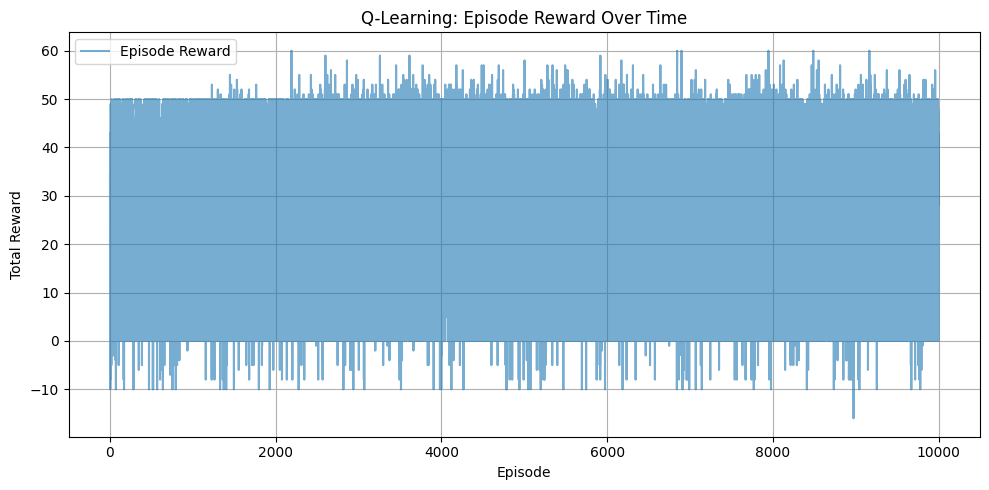

In [ ]:
# Plot the reward progression
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, alpha=0.6, label="Episode Reward")
plt.title("Q-Learning: Episode Reward Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

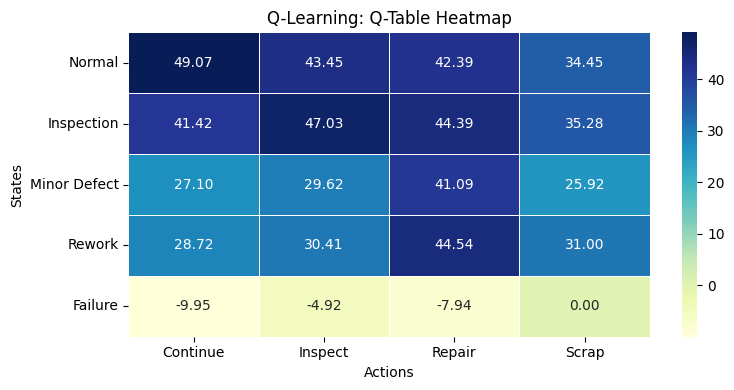

In [ ]:
import pandas as pd
import seaborn as sns
# Convert Q-table to DataFrame for better labeling
q_table_df = pd.DataFrame(Q, index=states, columns=actions)

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(q_table_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Q-Learning: Q-Table Heatmap")
plt.xlabel("Actions")
plt.ylabel("States")
plt.tight_layout()
plt.show()

#**Monte Carlo simulation code and validation results**

In [ ]:
# Monte Carlo Simulation & Validation

episodes = 10000
max_steps = 50
rewards = []
failures = 0
early_failures = 0
steps_to_failure = []
maintenance_costs = []
# Convert actions to index for lookup
action_index = {a: i for i, a in enumerate(actions)}
repair_intervals = []

# Initialize state visit counter
state_visits = np.zeros(len(states))

for i in range(episodes):
    state = 0
    total_reward = 0
    total_cost = 0
    repair_counts = 0
    steps_since_last_repair = 0
    repair_gaps = []
    for step in range(max_steps):
        state_visits[state] += 1
        if state == 4:  # Reached Failure
            steps_to_failure.append(step)
            early_threshold = int(max_steps * 0.5)  # 50% of steps
            if step < early_threshold:
                early_failures += 1
            failures += 1
            break

        result_action = best_policy[state]
        action_id = action_index[result_action]         # convert to index
        total_reward += R[state, action_id]             # accumulate reward
        # Maintenance cost
        if result_action == "Repair":
            total_cost += 40
            if steps_since_last_repair > 0:
                repair_gaps.append(steps_since_last_repair)
            steps_since_last_repair = 0
            repair_counts += 1
        elif result_action == "Inspect":
            total_cost += 5
            steps_since_last_repair += 1
        elif result_action == "Scrap":
            total_cost += 100
            steps_since_last_repair += 1
        else:
            steps_since_last_repair += 1

        state = simulate_transition(state, action_id)   # move to next state

    # Save average interval between repairs for this episode
    if repair_gaps:
        repair_intervals.append(np.mean(repair_gaps))
    rewards.append(total_reward)
    maintenance_costs.append(total_cost)


mtbf = np.mean(steps_to_failure) if steps_to_failure else 0
mtbr = np.mean(repair_intervals) if repair_intervals else 0

#Output Summary
print("Monte Carlo Validation:")
print("Average Reward:", round(np.mean(rewards),2))
print("Total Failures:", failures)
print("Early Failures:", early_failures)
print("Success Rate:", round((1 - failures / episodes) * 100,2), "%")
print("Estimated MTBF (steps):", round(mtbf,2))
print("Estimated MTBR (steps):", round(mtbr, 2))
print("Average Maintenance Cost per Episode:", round(np.mean(maintenance_costs),2),"$")
print("Total Reward:", np.sum(rewards))

Monte Carlo Validation:
Average Reward: 245.85
Total Failures: 219
Early Failures: 105
Success Rate: 97.81 %
Estimated MTBF (steps): 26.49
Estimated MTBR (steps): 25.39
Average Maintenance Cost per Episode: 16.98 $
Total Reward: 2458537


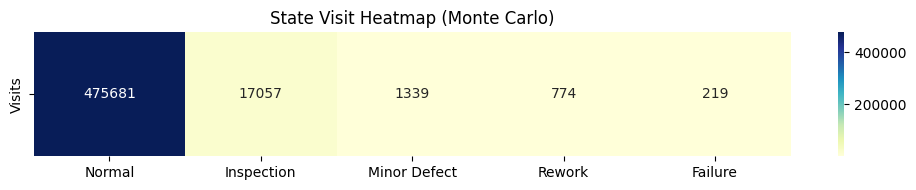

In [ ]:
# Convert to DataFrame for heatmap
visit_df = pd.DataFrame(state_visits.reshape(1, -1), columns=states, index=["Visits"])

# Plot the heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(visit_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("State Visit Heatmap (Monte Carlo)")
plt.tight_layout()
plt.show()

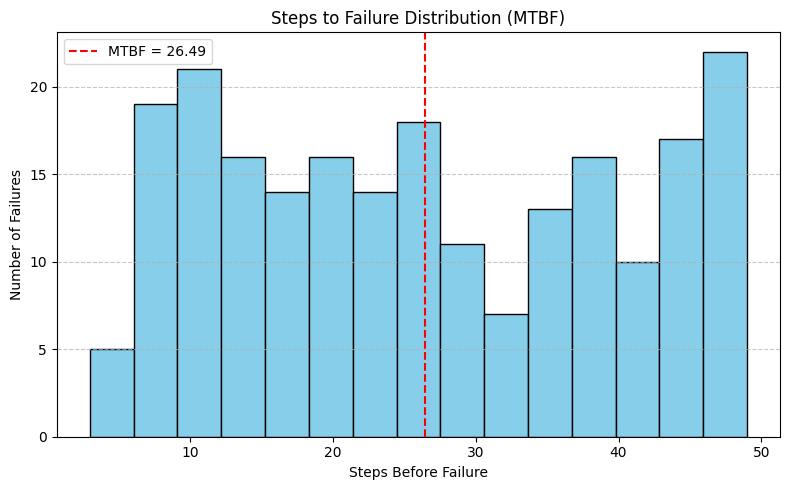

In [ ]:
np.random.seed(42)
# Plot histogram of steps before failure
plt.figure(figsize=(8, 5))
plt.hist(steps_to_failure, bins=15, edgecolor='black', color='skyblue')
plt.axvline(np.mean(steps_to_failure), color='red', linestyle='--', label=f"MTBF = {np.mean(steps_to_failure):.2f}")
plt.title("Steps to Failure Distribution (MTBF)")
plt.xlabel("Steps Before Failure")
plt.ylabel("Number of Failures")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()